**Mount Google Drive and unzip the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/CASCADE-master.zip

Archive:  /content/drive/MyDrive/CASCADE-master.zip
   creating: CASCADE-master/
  inflating: __MACOSX/._CASCADE-master  
  inflating: CASCADE-master/CASCADE_presentation_ppt_final.pdf  
  inflating: __MACOSX/CASCADE-master/._CASCADE_presentation_ppt_final.pdf  
  inflating: CASCADE-master/final_test_data.csv  
  inflating: __MACOSX/CASCADE-master/._final_test_data.csv  
  inflating: CASCADE-master/test_content_embeddings.csv.csv  
  inflating: __MACOSX/CASCADE-master/._test_content_embeddings.csv.csv  
  inflating: CASCADE-master/.DS_Store  
  inflating: __MACOSX/CASCADE-master/._.DS_Store  
  inflating: CASCADE-master/requirements.txt  
  inflating: __MACOSX/CASCADE-master/._requirements.txt  
  inflating: CASCADE-master/overall_model.jpg  
  inflating: __MACOSX/CASCADE-master/._overall_model.jpg  
  inflating: CASCADE-master/comments.json  
  inflating: __MACOSX/CASCADE-master/._comments.json  
  inflating: CASCADE-master/cca.jpg  
  inflating: __MACOSX/CASCADE-master/._cca.jpg  
  

**Data Preprocessing**

Clean and prepare comments data from JSON and CSV files for further analysis.

In [ ]:
import json
import numpy as np
import pandas as pd
from collections import defaultdict
import re

# Paths to your data files
comments_file_path = r"CASCADE-master/comments.json"
train_map_file = r"CASCADE-master/data/my_train_balanced.csv"
test_map_file = r"CASCADE-master/data/my_test_balanced.csv"
# Load comments.json
with open(comments_file_path, 'r') as f:
    comments = json.load(f)

def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

def build_data_cv(data_folder, comments, cv=10, clean_string=True):
    revs = []
    vocab = defaultdict(float)

    train_data = np.asarray(pd.read_csv(data_folder[0], header=None))
    test_data = np.asarray(pd.read_csv(data_folder[1], header=None))

    for line in train_data:
        comment_id = str(line[0])
        if comment_id in comments:
            rev = []
            label_str = line[2]
            label = [1, 0] if label_str == 0 else [0, 1]
            rev.append(comments[comment_id]['text'].strip())
            if clean_string:
                orig_rev = clean_str(" ".join(rev))
            else:
                orig_rev = " ".join(rev).lower()
            words = set(orig_rev.split())
            for word in words:
                vocab[word] += 1
            orig_rev = " ".join(orig_rev.split()[:100])
            datum = {
                "y": int(1),
                "id": comment_id,
                "text": orig_rev,
                "author": comments[comment_id]['author'],
                "topic": comments[comment_id]['subreddit'],
                "label": label,
                "num_words": len(orig_rev.split()),
                "split": int(1)
            }
            revs.append(datum)

    for line in test_data:
        comment_id = str(line[0])
        if comment_id in comments:
            rev = []
            label_str = line[2]
            label = [1, 0] if label_str == 0 else [0, 1]
            rev.append(comments[comment_id]['text'].strip())
            if clean_string:
                orig_rev = clean_str(" ".join(rev))
            else:
                orig_rev = " ".join(rev).lower()
            words = set(orig_rev.split())
            for word in words:
                vocab[word] += 1
            orig_rev = " ".join(orig_rev.split()[:100])
            datum = {
                "y": int(1),
                "id": comment_id,
                "text": orig_rev,
                "author": comments[comment_id]['author'],
                "topic": comments[comment_id]['subreddit'],
                "label": label,
                "num_words": len(orig_rev.split()),
                "split": int(0)
            }
            revs.append(datum)

    return revs, vocab

data_folder = [train_map_file, test_map_file]
revs, vocab = build_data_cv(data_folder, comments, cv=10, clean_string=True)

# Check the data
print(f"Number of sentences: {len(revs)}")
print(f"Vocab size: {len(vocab)}")


Number of sentences: 219368
Vocab size: 74408


**Stylometric embeddings generation**

Generate stylometric embeddings for user posts using the BERT model.

In [ ]:
import os
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch

# Paths to your data files
train_user_file = "CASCADE-master/users/train_user.csv"

# Load the user training data
train_user_data = pd.read_csv(train_user_file, header=None)

# Prepare the data for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class UserDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user_id = self.data.iloc[idx, 0]
        posts = self.data.iloc[idx, 1]
        encoding = self.tokenizer.encode_plus(
            posts,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,  # Ensure truncation
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'user_id': user_id,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Parameters for the BERT model
max_len = 512
batch_size = 8
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Create Dataset and DataLoader
dataset = UserDataset(train_user_data, tokenizer, max_len)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load the BERT model
model = BertModel.from_pretrained('bert-base-uncased')
model = model.to(device)

# Generate stylometric embeddings for each user
user_embeddings = {}

model.eval()
with torch.no_grad():
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        user_ids = batch['user_id']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

        for user_id, embedding in zip(user_ids, embeddings):
            user_embeddings[user_id] = embedding

# Save the stylometric embeddings to a file
stylometric_embeddings_file = "CASCADE-master/stylometric_embeddings_bert.csv"
with open(stylometric_embeddings_file, 'w') as f:
    for user_id, embedding in user_embeddings.items():
        f.write(f"{user_id},{','.join(map(str, embedding))}\n")

print(f"Stylometric embeddings saved to {stylometric_embeddings_file}")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please u

Stylometric embeddings saved to CASCADE-master/stylometric_embeddings_bert.csv


**Personality embeddings generation**

Generate personality embeddings from personality essays using BERT.

In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch

# Paths to your data files
personality_essay_file = "CASCADE-master/data/personality_essay.csv"

# Load the personality essay data with the correct encoding
personality_essay_data = pd.read_csv(personality_essay_file, encoding='ISO-8859-1')

# Prepare the data for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class PersonalityDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        essay = self.data.iloc[idx]['TEXT']  # Correct column name for essay text
        user_id = self.data.iloc[idx]['#AUTHID']  # Correct column name for user ID
        encoding = self.tokenizer.encode_plus(
            essay,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,  # Ensure the sequence is truncated to max_length
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'user_id': user_id,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Parameters for the BERT model
max_len = 512
batch_size = 8
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Create Dataset and DataLoader
dataset = PersonalityDataset(personality_essay_data, tokenizer, max_len)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load the BERT model
model = BertModel.from_pretrained('bert-base-uncased')
model = model.to(device)

# Generate personality embeddings for each user
personality_embeddings = {}

model.eval()
with torch.no_grad():
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        user_ids = batch['user_id']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

        for user_id, embedding in zip(user_ids, embeddings):
            personality_embeddings[user_id] = embedding  # No need for .item() since user_id is a string

# Save the personality embeddings to a file
personality_embeddings_file = "CASCADE-master/personality_embeddings.csv"
with open(personality_embeddings_file, 'w') as f:
    for user_id, embedding in personality_embeddings.items():
        f.write(f"{user_id},{','.join(map(str, embedding))}\n")

print(f"Personality embeddings saved to {personality_embeddings_file}")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please u

Personality embeddings saved to CASCADE-master/personality_embeddings.csv


**Generate Discourse Embeddings**

Generate topic-related discourse embeddings using BERTopic on Reddit data.

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

# Paths to your data files
train_topics_file = "CASCADE-master/discourse/train_topics.csv"

# Load the topic training data
train_topics_data = pd.read_csv(train_topics_file, header=None)

# Prepare the data for BERTopic
documents = train_topics_data[1].tolist()
topic_ids = train_topics_data[0].tolist()

# Display a sample
print(f"Sample document: {documents[0]}")

# Initialize BERTopic model
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")
bertopic_model = BERTopic(vectorizer_model=vectorizer_model)

# Fit the BERTopic model
topics, probabilities = bertopic_model.fit_transform(documents)

# Ensure the lengths match
if len(topic_ids) != len(probabilities):
    raise ValueError("The number of topic IDs does not match the number of probabilities.")

# Map topic IDs to embeddings (probabilities are vectors of floats)
discourse_embeddings_dict = {topic_id: probabilities[idx] for idx, topic_id in enumerate(topic_ids)}

# Save the discourse embeddings to a file
discourse_embeddings_file = "CASCADE-master/discourse_embeddings.csv"
with open(discourse_embeddings_file, 'w') as f:
    for topic_id, embedding in discourse_embeddings_dict.items():
        f.write(f"{topic_id},{','.join(map(str, embedding.flatten()))}\n")

print(f"Discourse embeddings saved to {discourse_embeddings_file}")


Sample document: this flair suits me. <END> But Shuichi is already a girl! <END> Link her to the V3 spoiler megathread; she'll be hooked right in <END> He reacted like that because the anime isn't really considered to be good quality, at least not nearly as good as the game itself. <END> ... there are 10 Vita games? <END> Ngl I voted for Kirigiri on some local positions that had no other candidates and I didn't want to vote for the one listed. <END> They will get Siri to voice him <END> Brb orchestrating global conflict and mass suicides with this vid thanks <END> There's already an official discord... <END> Mikan, but I don't know how they would change it without making it so gory. <END> Lay down. <END> Kodaka is western? <END> Wow, thanks for the spoiler <END> And of course Seiko wears lewd panties. <END> You mean like how there was nothing more to Monomi? <END> Oh My God That is... well... Monokuma's voice is not exactly fitting, but the rest doesn't seem too bad. <END> "wtf Junko h

**Generate Content Embeddings**

Extract comment text and create content embeddings using BERT for both training and test sets

In [ ]:
import json
import pandas as pd

# Step 1: Load the Data
comments_file_path = r"CASCADE-master/comments.json"
train_map_file = r"CASCADE-master/data/my_train_balanced.csv"
test_map_file = r"CASCADE-master/data/my_test_balanced.csv"

# Load comments.json
with open(comments_file_path, 'r') as f:
    comments = json.load(f)

# Load the training and testing data
train_data = pd.read_csv(train_map_file, header=None, names=["comment_id", "related_comment_id", "label"])
test_data = pd.read_csv(test_map_file, header=None, names=["comment_id", "related_comment_id", "label"])

# Step 2: Extract Comment Texts
def get_comment_text(comment_id, comments_dict):
    return comments_dict.get(comment_id, {}).get("text", "")

# Step 3: Create New Datasets
def prepare_dataset(data, comments):
    texts = []
    labels = []
    for _, row in data.iterrows():
        comment_id = str(row["comment_id"])
        text = get_comment_text(comment_id, comments)
        if text:
            texts.append(text)
            labels.append(row["label"])
    return pd.DataFrame({"text": texts, "label": labels})

# Prepare the datasets
final_train_data = prepare_dataset(train_data, comments)
final_test_data = prepare_dataset(test_data, comments)

# Display a sample from the datasets
print("Sample from final_train_data:")
print(final_train_data.head())

print("\nSample from final_test_data:")
print(final_test_data.head())

# Save the final datasets to CSV files
final_train_data.to_csv("CASCADE-master/final_train_data.csv", index=False)
final_test_data.to_csv("CASCADE-master/final_test_data.csv", index=False)

print(f"Final train data saved to /content/CASCADE-master/final_train_data.csv")
print(f"Final test data saved to /content/CASCADE-master/final_test_data.csv")


Sample from final_train_data:
                                                text  label
0                      Religion must have the answer      1
1  It's obviously tracks from a giant water tract...      0
2  Wow...he smoked pot...oh lord hes such a horri...      1
3  Wow, his girlfriend is uhm... Ah fuck it, he's...      0
4  I think the government should track every morm...      0

Sample from final_test_data:
                                                text  label
0        Yes, cuz tax cuts will help those w/o jobs!      1
1        If cutting taxes fails... cut taxes harder.      0
2  Chalk it up to the ever-increasing cost of fre...      1
3  We're about to finally get affordable housing,...      0
4   oh wow I am so surprised I never saw this coming      1
Final train data saved to /content/CASCADE-master/final_train_data.csv
Final test data saved to /content/CASCADE-master/final_test_data.csv


In [ ]:
import os
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch

# Paths to your data files
train_data_file = "CASCADE-master/final_train.csv"
test_data_file = "CASCADE-master/final_test.csv"

# Load the training and testing data
train_data = pd.read_csv(train_data_file)
test_data = pd.read_csv(test_data_file)

# Check for missing values
print(f"Missing values in train data before cleaning: {train_data['text'].isnull().sum()}")
print(f"Missing values in test data before cleaning: {test_data['text'].isnull().sum()}")

# Drop rows with missing values
train_data = train_data.dropna(subset=['text'])
test_data = test_data.dropna(subset=['text'])

# Check again for any missing values
print(f"Missing values in train data after dropping: {train_data['text'].isnull().sum()}")
print(f"Missing values in test data after dropping: {test_data['text'].isnull().sum()}")

# If any NaNs still remain, fill them with a placeholder
train_data['text'] = train_data['text'].fillna("placeholder text")
test_data['text'] = test_data['text'].fillna("placeholder text")

# Validate no missing values remain
assert train_data['text'].isnull().sum() == 0, "There are still missing values in train data"
assert test_data['text'].isnull().sum() == 0, "There are still missing values in test data"

# Prepare the data for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class CommentDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,  # Ensure truncation
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Parameters for the BERT model
max_len = 512
batch_size = 8
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Create Dataset and DataLoader for train and test datasets
train_dataset = CommentDataset(train_data, tokenizer, max_len)
test_dataset = CommentDataset(test_data, tokenizer, max_len)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the BERT model
model = BertModel.from_pretrained('bert-base-uncased')
model = model.to(device)

# Function to generate embeddings
def generate_embeddings(dataloader, model, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

            embeddings.extend(pooled_output)
    return embeddings

# Generate content embeddings for training and testing data
train_content_embeddings = generate_embeddings(train_dataloader, model, device)
test_content_embeddings = generate_embeddings(test_dataloader, model, device)

# Save the content embeddings to files
train_content_embeddings_file = "CASCADE-master/train_content_embeddings.csv"
test_content_embeddings_file = "CASCADE-master/test_content_embeddings.csv"

# Save the embeddings along with the labels
train_data['embeddings'] = train_content_embeddings
test_data['embeddings'] = test_content_embeddings

train_data.to_csv(train_content_embeddings_file, index=False)
test_data.to_csv(test_content_embeddings_file, index=False)

print(f"Train content embeddings saved to {train_content_embeddings_file}")
print(f"Test content embeddings saved to {test_content_embeddings_file}")


Missing values in train data before cleaning: 2
Missing values in test data before cleaning: 2
Missing values in train data after dropping: 0
Missing values in test data after dropping: 0


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Train content embeddings saved to CASCADE-master/train_content_embeddings.csv
Test content embeddings saved to CASCADE-master/test_content_embeddings.csv


**Data Preprocessing of Embeddings**

Preprocess all embeddings (imputation and scaling) to ensure data consistency for modeling.

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Device configuration: Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Paths to your embedding files
stylometric_embeddings_file = "/content/CASCADE-master/stylometric_embeddings_bert.csv"
personality_embeddings_file = "/content/CASCADE-master/personality_embeddings_bert-2.csv"
discourse_embeddings_file = "/content/CASCADE-master/discourse/discourse_features/discourse.csv"
train_content_embeddings_file = "/content/CASCADE-master/train_content_embeddings.csv"
test_content_embeddings_file = "/content/CASCADE-master/test_content_embeddings.csv"


# Load embeddings
stylometric_embeddings = pd.read_csv(stylometric_embeddings_file, header=None)
personality_embeddings = pd.read_csv(personality_embeddings_file, header=None)
discourse_embeddings = pd.read_csv(discourse_embeddings_file, header=None)
train_content_embeddings = pd.read_csv(train_content_embeddings_file, header=None)
test_content_embeddings = pd.read_csv(test_content_embeddings_file, header=None)

# Convert all data to numeric, coercing errors to NaN (which we will then impute)
stylometric_embeddings = stylometric_embeddings.apply(pd.to_numeric, errors='coerce')
personality_embeddings = personality_embeddings.apply(pd.to_numeric, errors='coerce')
discourse_embeddings = discourse_embeddings.apply(pd.to_numeric, errors='coerce')
train_content_embeddings = train_content_embeddings.apply(pd.to_numeric, errors='coerce')
test_content_embeddings = test_content_embeddings.apply(pd.to_numeric, errors='coerce')

# Identify columns that are entirely NaN and drop them
stylometric_embeddings = stylometric_embeddings.dropna(axis=1, how='all')
personality_embeddings = personality_embeddings.dropna(axis=1, how='all')
discourse_embeddings = discourse_embeddings.dropna(axis=1, how='all')
train_content_embeddings = train_content_embeddings.dropna(axis=1, how='all')
test_content_embeddings = test_content_embeddings.dropna(axis=1, how='all')

# Impute missing values using the mean of each column
imputer = SimpleImputer(strategy='mean')
stylometric_embeddings = pd.DataFrame(imputer.fit_transform(stylometric_embeddings))
personality_embeddings = pd.DataFrame(imputer.fit_transform(personality_embeddings))
discourse_embeddings = pd.DataFrame(imputer.fit_transform(discourse_embeddings))
train_content_embeddings = pd.DataFrame(imputer.fit_transform(train_content_embeddings))
test_content_embeddings = pd.DataFrame(imputer.fit_transform(test_content_embeddings))

# Verify the shape of dataframes after imputation
print("Shapes after imputing missing values:")
print(stylometric_embeddings.shape)
print(personality_embeddings.shape)
print(discourse_embeddings.shape)
print(train_content_embeddings.shape)
print(test_content_embeddings.shape)


Shapes after imputing missing values:
(283591, 769)
(2468, 768)
(16327, 101)
(64665, 2)
(64665, 2)


**Autoencoder-Based Embedding Fusion**

Train an autoencoder to fuse stylometric, personality, discourse, and content embeddings into a unified representation.

In [ ]:

import pandas as pd
import numpy as np
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim

# Device configuration: Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Paths to your embedding files
stylometric_embeddings_file = "CASCADE-master/stylometric_embeddings_bert.csv.csv"
personality_embeddings_file = "CASCADE-master/personality_embeddings_bert-2.csv.csv"
discourse_embeddings_file = "CASCADE-master/discourse/discourse_features/discourse.csv"
train_content_embeddings_file = "CASCADE-master/train_content_embeddings.csv.csv"
test_content_embeddings_file = "CASCADE-master/test_content_embeddings.csv.csv"

# Load embeddings
stylometric_embeddings = pd.read_csv(stylometric_embeddings_file, header=None)
personality_embeddings = pd.read_csv(personality_embeddings_file, header=None)
discourse_embeddings = pd.read_csv(discourse_embeddings_file, header=None)
train_content_embeddings = pd.read_csv(train_content_embeddings_file, header=None)
test_content_embeddings = pd.read_csv(test_content_embeddings_file, header=None)

# Convert all data to numeric, coercing errors to NaN (which we will then impute)
stylometric_embeddings = stylometric_embeddings.apply(pd.to_numeric, errors='coerce')
personality_embeddings = personality_embeddings.apply(pd.to_numeric, errors='coerce')
discourse_embeddings = discourse_embeddings.apply(pd.to_numeric, errors='coerce')
train_content_embeddings = train_content_embeddings.apply(pd.to_numeric, errors='coerce')
test_content_embeddings = test_content_embeddings.apply(pd.to_numeric, errors='coerce')

# Identify columns that are entirely NaN and drop them
stylometric_embeddings = stylometric_embeddings.dropna(axis=1, how='all')
personality_embeddings = personality_embeddings.dropna(axis=1, how='all')
discourse_embeddings = discourse_embeddings.dropna(axis=1, how='all')
train_content_embeddings = train_content_embeddings.dropna(axis=1, how='all')
test_content_embeddings = test_content_embeddings.dropna(axis=1, how='all')

# Impute missing values using the mean of each column
imputer = SimpleImputer(strategy='mean')
stylometric_embeddings = pd.DataFrame(imputer.fit_transform(stylometric_embeddings))
personality_embeddings = pd.DataFrame(imputer.fit_transform(personality_embeddings))
discourse_embeddings = pd.DataFrame(imputer.fit_transform(discourse_embeddings))
train_content_embeddings = pd.DataFrame(imputer.fit_transform(train_content_embeddings))
test_content_embeddings = pd.DataFrame(imputer.fit_transform(test_content_embeddings))

# Ensure the same number of rows in each dataframe before concatenation
min_rows = min(len(stylometric_embeddings), len(personality_embeddings), len(discourse_embeddings), len(train_content_embeddings))
stylometric_embeddings = stylometric_embeddings.iloc[:min_rows]
personality_embeddings = personality_embeddings.iloc[:min_rows]
discourse_embeddings = discourse_embeddings.iloc[:min_rows]
train_content_embeddings = train_content_embeddings.iloc[:min_rows]

min_rows_test = min(len(stylometric_embeddings), len(personality_embeddings), len(discourse_embeddings), len(test_content_embeddings))
test_content_embeddings = test_content_embeddings.iloc[:min_rows_test]

# Concatenate the embeddings for training and testing datasets
train_embeddings = pd.concat([stylometric_embeddings, personality_embeddings, discourse_embeddings, train_content_embeddings], axis=1)
test_embeddings = pd.concat([stylometric_embeddings.iloc[:min_rows_test],
                             personality_embeddings.iloc[:min_rows_test],
                             discourse_embeddings.iloc[:min_rows_test],
                             test_content_embeddings], axis=1)

# For the purpose of this example, assume the labels are the last column in train_embeddings
# You might need to adjust this depending on your actual dataset
train_labels = train_embeddings.iloc[:, -1]
test_labels = test_embeddings.iloc[:, -1]

train_embeddings = train_embeddings.iloc[:, :-1]
test_embeddings = test_embeddings.iloc[:, :-1]

# Standardize the embeddings
scaler = StandardScaler()

# Cap extreme values before scaling
max_value = 1e6  # Define a reasonable maximum value (adjust based on your dataset)
min_value = -1e6  # Define a reasonable minimum value (adjust based on your dataset)

train_embeddings_clipped = train_embeddings.clip(lower=min_value, upper=max_value)
test_embeddings_clipped = test_embeddings.clip(lower=min_value, upper=max_value)

# Re-apply scaling after clipping
train_embeddings_scaled = scaler.fit_transform(train_embeddings_clipped)
test_embeddings_scaled = scaler.transform(test_embeddings_clipped)

print("Min value in train_embeddings_scaled after clipping:", train_embeddings_scaled.min())
print("Max value in train_embeddings_scaled after clipping:", train_embeddings_scaled.max())

# Convert to tensors
train_embeddings_tensor = torch.tensor(train_embeddings_scaled, dtype=torch.float32).to(device)
test_embeddings_tensor = torch.tensor(test_embeddings_scaled, dtype=torch.float32).to(device)

# Define the autoencoder for embedding fusion
class EmbeddingFusionAutoencoder(nn.Module):
    def __init__(self, input_dim, fusion_dim):
        super(EmbeddingFusionAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, fusion_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(fusion_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

# Parameters
input_dim = train_embeddings_scaled.shape[1]
fusion_dim = 100  # Dimensionality of the fused embedding
learning_rate = 0.0001
epochs = 20

# Initialize the autoencoder model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = EmbeddingFusionAutoencoder(input_dim, fusion_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Training loop for the autoencoder
autoencoder.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    fused_embeddings, reconstructed_embeddings = autoencoder(train_embeddings_tensor)
    loss = criterion(reconstructed_embeddings, train_embeddings_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

# Get the fused embeddings
autoencoder.eval()
with torch.no_grad():
    fused_train_embeddings, _ = autoencoder(train_embeddings_tensor)
    fused_test_embeddings, _ = autoencoder(test_embeddings_tensor)

print("Fusion using autoencoder completed.")



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.p

Min value in train_embeddings_scaled after clipping: -49.66890375275058
Max value in train_embeddings_scaled after clipping: 18.259056362284237
Epoch 1/50, Loss: 1.0034946203231812
Epoch 2/50, Loss: 1.0006121397018433
Epoch 3/50, Loss: 0.9980453252792358
Epoch 4/50, Loss: 0.9956052303314209
Epoch 5/50, Loss: 0.9931245446205139
Epoch 6/50, Loss: 0.9904623031616211
Epoch 7/50, Loss: 0.9875165820121765
Epoch 8/50, Loss: 0.9842116236686707
Epoch 9/50, Loss: 0.9804891347885132
Epoch 10/50, Loss: 0.9763064384460449
Epoch 11/50, Loss: 0.9716276526451111
Epoch 12/50, Loss: 0.9664289951324463
Epoch 13/50, Loss: 0.9606896638870239
Epoch 14/50, Loss: 0.954397439956665
Epoch 15/50, Loss: 0.9475470185279846
Epoch 16/50, Loss: 0.9401459097862244
Epoch 17/50, Loss: 0.9322148561477661
Epoch 18/50, Loss: 0.9237911701202393
Epoch 19/50, Loss: 0.9149307608604431
Epoch 20/50, Loss: 0.9057106375694275
Epoch 21/50, Loss: 0.8962305784225464
Epoch 22/50, Loss: 0.886611819267273
Epoch 23/50, Loss: 0.8769860267

**Stylometric embeddings for classification**

Use a CNN-based model with multi-head attention for sarcasm classification on Stylometric embeddings.

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import classification_report
from tqdm import tqdm
from transformers import BertModel, BertTokenizer
import pandas as pd
import json
import numpy as np
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Define the autoencoder for embedding fusion
class EmbeddingFusionAutoencoder(nn.Module):
    def __init__(self, input_dim, fusion_dim):
        super(EmbeddingFusionAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, fusion_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(fusion_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

# Load and preprocess embeddings
def load_embeddings(file_path):
    embeddings = pd.read_csv(file_path, header=None)
    embeddings = embeddings.apply(pd.to_numeric, errors='coerce')
    embeddings = embeddings.dropna(axis=1, how='all')
    imputer = SimpleImputer(strategy='mean')
    embeddings = pd.DataFrame(imputer.fit_transform(embeddings))
    return embeddings

stylometric_embeddings = load_embeddings("/content/CASCADE-master/stylometric_embeddings_bert.csv.csv")
train_content_embeddings = load_embeddings("/content/CASCADE-master/train_content_embeddings.csv.csv")
test_content_embeddings = load_embeddings("/content/CASCADE-master/test_content_embeddings.csv.csv")

# Ensure the same number of rows in each dataframe before concatenation
min_rows = min(len(stylometric_embeddings), len(train_content_embeddings))
stylometric_embeddings = stylometric_embeddings.iloc[:min_rows]
train_content_embeddings = train_content_embeddings.iloc[:min_rows]

min_rows_test = min(len(stylometric_embeddings), len(test_content_embeddings))
test_content_embeddings = test_content_embeddings.iloc[:min_rows_test]

# Concatenate the embeddings for training and testing datasets
train_embeddings = pd.concat([stylometric_embeddings, train_content_embeddings], axis=1)
test_embeddings = pd.concat([stylometric_embeddings.iloc[:min_rows_test],
                             test_content_embeddings], axis=1)

# For the purpose of this example, assume the labels are the last column in train_embeddings
train_labels = train_embeddings.iloc[:, -1]
test_labels = test_embeddings.iloc[:, -1]

train_embeddings = train_embeddings.iloc[:, :-1]
test_embeddings = test_embeddings.iloc[:, :-1]

# Standardize the embeddings
scaler = StandardScaler()
train_embeddings_scaled = scaler.fit_transform(train_embeddings)
test_embeddings_scaled = scaler.transform(test_embeddings)

# Parameters for the autoencoder
input_dim = train_embeddings_scaled.shape[1]
fusion_dim = 100  # Dimensionality of the fused embedding
learning_rate = 0.001
epochs = 20

# Initialize the autoencoder model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = EmbeddingFusionAutoencoder(input_dim, fusion_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Prepare the data for the autoencoder
train_embeddings_tensor = torch.tensor(train_embeddings_scaled, dtype=torch.float32).to(device)
test_embeddings_tensor = torch.tensor(test_embeddings_scaled, dtype=torch.float32).to(device)

# Training loop for the autoencoder
autoencoder.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    fused_embeddings, reconstructed_embeddings = autoencoder(train_embeddings_tensor)
    loss = criterion(reconstructed_embeddings, train_embeddings_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

# Get the fused embeddings
autoencoder.eval()
with torch.no_grad():
    fused_train_embeddings, _ = autoencoder(train_embeddings_tensor)
    fused_test_embeddings, _ = autoencoder(test_embeddings_tensor)

print("Fusion using autoencoder completed.")

# Define the CNN-based model with multi-head attention for classification
class EnhancedCNNClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EnhancedCNNClassifier, self).__init__()
        # BERT for Initial Embedding Extraction (with fine-tuning)
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        # Multi-Head Attention
        self.multihead_attn = nn.MultiheadAttention(embed_dim=64, num_heads=8)
        # Fully connected layers
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, output_dim)
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
        # Layer Normalization
        self.layer_norm = nn.LayerNorm(64)

    def forward(self, input_ids, attention_mask):
        # Fine-tune BERT
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x = x.permute(0, 2, 1)  # Rearrange to (batch_size, hidden_size, sequence_length)
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2)

        # Reshape for multi-head attention
        x = x.permute(2, 0, 1)  # (seq_len, batch, embed_dim)
        x, _ = self.multihead_attn(x, x, x)
        x = x.permute(1, 2, 0)  # (batch, embed_dim, seq_len)

        # Collapse sequence length and apply layer normalization
        x = x.mean(dim=2)  # Apply mean pooling to collapse sequence length
        x = self.layer_norm(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Function to prepare datasets
def prepare_datasets():
    # Load the data
    comments_file_path = r"/content/CASCADE-master/comments.json"
    train_map_file = r"/content/CASCADE-master/data/my_train_balanced.csv"
    test_map_file = r"/content/CASCADE-master/data/my_test_balanced.csv.csv"

    # Load comments.json
    with open(comments_file_path, 'r') as f:
        comments = json.load(f)

    # Load the training and testing data
    train_data = pd.read_csv(train_map_file, header=None, names=["comment_id", "related_comment_id", "label"])
    test_data = pd.read_csv(test_map_file, header=None, names=["comment_id", "related_comment_id", "label"])

    # Extract Comment Texts
    def get_comment_text(comment_id, comments_dict):
        return comments_dict.get(comment_id, {}).get("text", "")

    # Create New Datasets
    def prepare_dataset(data, comments):
        texts = []
        labels = []
        for _, row in data.iterrows():
            comment_id = str(row["comment_id"])
            text = get_comment_text(comment_id, comments)
            if text:
                texts.append(text)
                labels.append(row["label"])
        return pd.DataFrame({"text": texts, "label": labels})

    # Prepare the datasets
    final_train_data = prepare_dataset(train_data, comments)
    final_test_data = prepare_dataset(test_data, comments)

    return final_train_data, final_test_data

# Initialize the datasets
final_train_data, final_test_data = prepare_datasets()


# Parameters
max_len = 256
batch_size = 4
output_dim = len(np.unique(final_train_data['label']))  # Assuming labels are categorical
epochs = 20  # You can adjust this
learning_rate = 1e-5  # Lower learning rate for fine-tuning BERT
cnn_learning_rate = 1e-4  # Higher learning rate for the CNN and fully connected layers

# Prepare the data for BERT and CNN model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class CommentDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,  # Ensure truncation
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.data.iloc[idx]['label'], dtype=torch.long)  # Add labels to dataset


        }

# Initialize the model
model = EnhancedCNNClassifier(fusion_dim, output_dim).to(device)

# Define optimizer with different learning rates for BERT and the rest of the model
optimizer = optim.AdamW([
    {'params': model.bert.parameters(), 'lr': learning_rate},
    {'params': model.conv1.parameters(), 'lr': cnn_learning_rate},
    {'params': model.conv2.parameters(), 'lr': cnn_learning_rate},
    {'params': model.multihead_attn.parameters(), 'lr': cnn_learning_rate},
    {'params': model.fc1.parameters(), 'lr': cnn_learning_rate},
    {'params': model.fc2.parameters(), 'lr': cnn_learning_rate},
], weight_decay=0.01)

criterion = nn.CrossEntropyLoss()

# Create Dataset and DataLoader for training and testing
train_dataset = CommentDataset(final_train_data, tokenizer, max_len)
test_dataset = CommentDataset(final_test_data, tokenizer, max_len)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_dataloader)}")

# Save the model and optimizer state
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "model_checkpoint.pth")

print("Model saved successfully.")

# Evaluate the model
model.eval()
all_outputs = []
all_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        all_outputs.append(outputs)
        all_labels.append(labels)

    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    _, predicted = torch.max(all_outputs, 1)
    accuracy = (predicted == all_labels).sum().item() / all_labels.size(0)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Print classification report
    print(classification_report(all_labels.cpu(), predicted.cpu(), target_names=['Class 0', 'Class 1']))

# Loading the model
def load_model_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("Model and optimizer state loaded successfully.")

# Usage: load the model
load_model_checkpoint("model_checkpoint.pth", model, optimizer)



Epoch 1/20, Loss: 1.0044349431991577
Epoch 2/20, Loss: 0.9834804534912109
Epoch 3/20, Loss: 0.9298465847969055
Epoch 4/20, Loss: 0.8593040108680725
Epoch 5/20, Loss: 0.8427321314811707
Epoch 6/20, Loss: 0.7779587507247925
Epoch 7/20, Loss: 0.7457451820373535
Epoch 8/20, Loss: 0.7315701246261597
Epoch 9/20, Loss: 0.708585262298584
Epoch 10/20, Loss: 0.6818096041679382
Epoch 11/20, Loss: 0.6589361429214478
Epoch 12/20, Loss: 0.6418404579162598
Epoch 13/20, Loss: 0.6258410215377808
Epoch 14/20, Loss: 0.6092260479927063
Epoch 15/20, Loss: 0.5944201350212097
Epoch 16/20, Loss: 0.5814482569694519
Epoch 17/20, Loss: 0.5693575739860535
Epoch 18/20, Loss: 0.5575008988380432
Epoch 19/20, Loss: 0.5466176271438599
Epoch 20/20, Loss: 0.5360690951347351
Fusion using autoencoder completed.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 38676/38676 [35:14<00:00, 18.29it/s]


Epoch 1/20, Loss: 0.595106380700461


100%|██████████| 38676/38676 [35:10<00:00, 18.33it/s]


Epoch 2/20, Loss: 0.5238980172740038


100%|██████████| 38676/38676 [35:02<00:00, 18.39it/s]


Epoch 3/20, Loss: 0.44599507399914157


100%|██████████| 38676/38676 [35:10<00:00, 18.32it/s]


Epoch 4/20, Loss: 0.36619674375676664


100%|██████████| 38676/38676 [35:04<00:00, 18.38it/s]


Epoch 5/20, Loss: 0.29922622193194476


100%|██████████| 38676/38676 [35:07<00:00, 18.36it/s]


Epoch 6/20, Loss: 0.25913318385022144


100%|██████████| 38676/38676 [35:11<00:00, 18.32it/s]


Epoch 7/20, Loss: 0.22440730947309023


100%|██████████| 38676/38676 [35:13<00:00, 18.30it/s]


Epoch 8/20, Loss: 0.20223666611713004


100%|██████████| 38676/38676 [35:18<00:00, 18.26it/s]


Epoch 9/20, Loss: 0.18646877550866445


100%|██████████| 38676/38676 [35:14<00:00, 18.29it/s]


Epoch 10/20, Loss: 0.1786284168727004


100%|██████████| 38676/38676 [35:20<00:00, 18.24it/s]


Epoch 11/20, Loss: 0.1644717471638148


100%|██████████| 38676/38676 [35:18<00:00, 18.26it/s]


Epoch 12/20, Loss: 0.15446471971585168


100%|██████████| 38676/38676 [35:10<00:00, 18.33it/s]


Epoch 13/20, Loss: 0.14248078840811956


100%|██████████| 38676/38676 [35:10<00:00, 18.33it/s]


Epoch 14/20, Loss: 0.13477075420271417


100%|██████████| 38676/38676 [34:56<00:00, 18.45it/s]


Epoch 15/20, Loss: 0.12462071840615087


100%|██████████| 38676/38676 [34:59<00:00, 18.42it/s]


Epoch 16/20, Loss: 0.11674411929432477


100%|██████████| 38676/38676 [35:05<00:00, 18.37it/s]


Epoch 17/20, Loss: 0.1140348375832509


100%|██████████| 38676/38676 [35:06<00:00, 18.36it/s]


Epoch 18/20, Loss: 0.11200013838466723


100%|██████████| 38676/38676 [35:04<00:00, 18.38it/s]


Epoch 19/20, Loss: 0.1056238212945417


100%|██████████| 38676/38676 [35:04<00:00, 18.38it/s]


Epoch 20/20, Loss: 0.10147445012863837
Model saved successfully.
Accuracy: 68.23%
              precision    recall  f1-score   support

     Class 0       0.70      0.64      0.67     32333
     Class 1       0.67      0.73      0.70     32333

    accuracy                           0.68     64666
   macro avg       0.68      0.68      0.68     64666
weighted avg       0.68      0.68      0.68     64666

Model and optimizer state loaded successfully.


**Evaluation and Visualization**

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.70      0.64      0.67     32333
     Class 1       0.67      0.73      0.70     32333

    accuracy                           0.68     64666
   macro avg       0.68      0.68      0.68     64666
weighted avg       0.68      0.68      0.68     64666



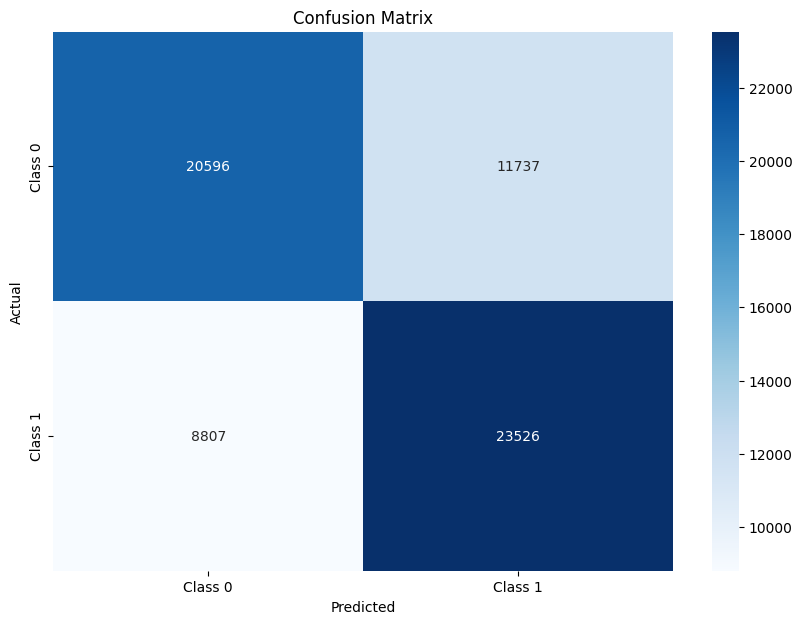

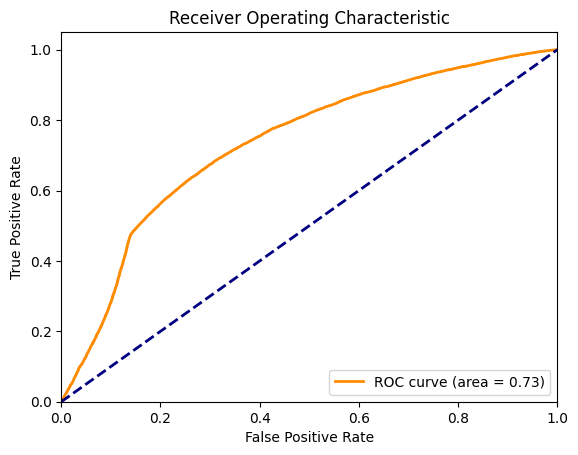

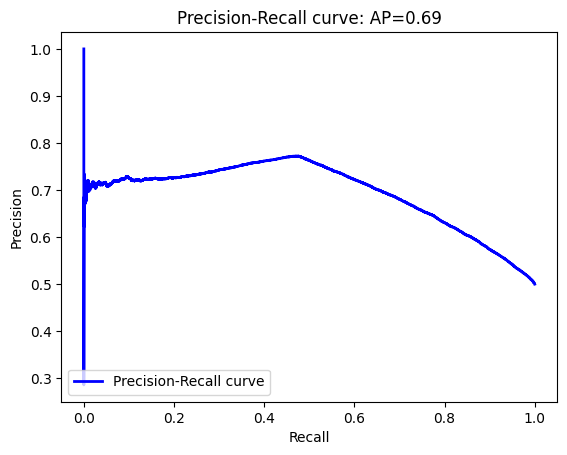

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# Print classification report
print("Classification Report:")
print(classification_report(all_labels.cpu(), predicted.cpu(), target_names=['Class 0', 'Class 1']))

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels.cpu(), predicted.cpu())
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Compute and plot ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels.cpu(), all_outputs[:, 1].cpu())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Compute and plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(all_labels.cpu(), all_outputs[:, 1].cpu())
average_precision = average_precision_score(all_labels.cpu(), all_outputs[:, 1].cpu())
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve: AP={average_precision:0.2f}')
plt.legend(loc="lower left")
plt.show()


**Fusion and classification without personality traits/embeddings**

Use a CNN-based model with multi-head attention for sarcasm classification on Fusion and classification without personality embeddings.

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel, BertTokenizer
from tqdm import tqdm
from sklearn.metrics import classification_report
import json  # Ensure json is imported

# Paths to your embedding files
stylometric_embeddings_file = "/content/CASCADE-master/stylometric_embeddings_bert.csv"
discourse_embeddings_file = "/content/CASCADE-master/discourse/discourse_features/discourse.csv"
train_content_embeddings_file = "/content/CASCADE-master/test_content_embeddings.csv"
test_content_embeddings_file = "/content/CASCADE-master/train_content_embeddings.csv"

# Load embeddings
stylometric_embeddings = pd.read_csv(stylometric_embeddings_file, header=None)
discourse_embeddings = pd.read_csv(discourse_embeddings_file, header=None)
train_content_embeddings = pd.read_csv(train_content_embeddings_file, header=None)
test_content_embeddings = pd.read_csv(test_content_embeddings_file, header=None)

# Convert all data to numeric, coercing errors to NaN (which we will then impute)
stylometric_embeddings = stylometric_embeddings.apply(pd.to_numeric, errors='coerce')
discourse_embeddings = discourse_embeddings.apply(pd.to_numeric, errors='coerce')
train_content_embeddings = train_content_embeddings.apply(pd.to_numeric, errors='coerce')
test_content_embeddings = test_content_embeddings.apply(pd.to_numeric, errors='coerce')

# Identify columns that are entirely NaN and drop them
stylometric_embeddings = stylometric_embeddings.dropna(axis=1, how='all')
discourse_embeddings = discourse_embeddings.dropna(axis=1, how='all')
train_content_embeddings = train_content_embeddings.dropna(axis=1, how='all')
test_content_embeddings = test_content_embeddings.dropna(axis=1, how='all')

# Impute missing values using the mean of each column
imputer = SimpleImputer(strategy='mean')
stylometric_embeddings = pd.DataFrame(imputer.fit_transform(stylometric_embeddings))
discourse_embeddings = pd.DataFrame(imputer.fit_transform(discourse_embeddings))
train_content_embeddings = pd.DataFrame(imputer.fit_transform(train_content_embeddings))
test_content_embeddings = pd.DataFrame(imputer.fit_transform(test_content_embeddings))

# Ensure the same number of rows in each dataframe before concatenation
min_rows = min(len(stylometric_embeddings), len(discourse_embeddings), len(train_content_embeddings))
stylometric_embeddings = stylometric_embeddings.iloc[:min_rows]
discourse_embeddings = discourse_embeddings.iloc[:min_rows]
train_content_embeddings = train_content_embeddings.iloc[:min_rows]

min_rows_test = min(len(stylometric_embeddings), len(discourse_embeddings), len(test_content_embeddings))
test_content_embeddings = test_content_embeddings.iloc[:min_rows_test]

# Concatenate the embeddings for training and testing datasets
train_embeddings = pd.concat([stylometric_embeddings, discourse_embeddings, train_content_embeddings], axis=1)
test_embeddings = pd.concat([stylometric_embeddings.iloc[:min_rows_test],
                             discourse_embeddings.iloc[:min_rows_test],
                             test_content_embeddings], axis=1)

# For the purpose of this example, assume the labels are the last column in train_embeddings
train_labels = train_embeddings.iloc[:, -1]
test_labels = test_embeddings.iloc[:, -1]

train_embeddings = train_embeddings.iloc[:, :-1]
test_embeddings = test_embeddings.iloc[:, :-1]

# Standardize the embeddings
scaler = StandardScaler()
train_embeddings_scaled = scaler.fit_transform(train_embeddings)
test_embeddings_scaled = scaler.transform(test_embeddings)

# Define the autoencoder for embedding fusion
class EmbeddingFusionAutoencoder(nn.Module):
    def __init__(self, input_dim, fusion_dim):
        super(EmbeddingFusionAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, fusion_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(fusion_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

# Parameters
input_dim = train_embeddings_scaled.shape[1]
fusion_dim = 100  # Dimensionality of the fused embedding
learning_rate = 0.001
epochs = 350

# Initialize the autoencoder model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = EmbeddingFusionAutoencoder(input_dim, fusion_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Prepare the data for the autoencoder
train_embeddings_tensor = torch.tensor(train_embeddings_scaled, dtype=torch.float32).to(device)
test_embeddings_tensor = torch.tensor(test_embeddings_scaled, dtype=torch.float32).to(device)

# Training loop for the autoencoder
autoencoder.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    fused_embeddings, reconstructed_embeddings = autoencoder(train_embeddings_tensor)
    loss = criterion(reconstructed_embeddings, train_embeddings_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

# Get the fused embeddings
autoencoder.eval()
with torch.no_grad():
    fused_train_embeddings, _ = autoencoder(train_embeddings_tensor)
    fused_test_embeddings, _ = autoencoder(test_embeddings_tensor)

print("Fusion using autoencoder completed.")


# Define the autoencoder for embedding fusion
class EmbeddingFusionAutoencoder(nn.Module):
    def __init__(self, input_dim, fusion_dim):
        super(EmbeddingFusionAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, fusion_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(fusion_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

# Parameters
input_dim = train_embeddings_scaled.shape[1]
fusion_dim = 100  # Dimensionality of the fused embedding
learning_rate = 0.001
epochs = 20

# Initialize the autoencoder model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = EmbeddingFusionAutoencoder(input_dim, fusion_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Prepare the data for the autoencoder
train_embeddings_tensor = torch.tensor(train_embeddings_scaled, dtype=torch.float32).to(device)
test_embeddings_tensor = torch.tensor(test_embeddings_scaled, dtype=torch.float32).to(device)

# Training loop for the autoencoder
autoencoder.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    fused_embeddings, reconstructed_embeddings = autoencoder(train_embeddings_tensor)
    loss = criterion(reconstructed_embeddings, train_embeddings_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

# Get the fused embeddings
autoencoder.eval()
with torch.no_grad():
    fused_train_embeddings, _ = autoencoder(train_embeddings_tensor)
    fused_test_embeddings, _ = autoencoder(test_embeddings_tensor)

print("Fusion using autoencoder completed.")


# Define the CNN-based model with multi-head attention for classification
class EnhancedCNNClassifier(nn.Module):
    def __init__(self, output_dim):
        super(EnhancedCNNClassifier, self).__init__()
        # BERT for Initial Embedding Extraction
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        # Multi-Head Attention
        self.multihead_attn = nn.MultiheadAttention(embed_dim=64, num_heads=8)
        # Fully connected layers
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, output_dim)
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
        # Layer Normalization
        self.layer_norm = nn.LayerNorm(64)

    def forward(self, input_ids, attention_mask):
        # Fine-tune BERT
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x = x.permute(0, 2, 1)  # Rearrange to (batch_size, hidden_size, sequence_length)
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2)

        # Reshape for multi-head attention
        x = x.permute(2, 0, 1)  # (seq_len, batch, embed_dim)
        x, _ = self.multihead_attn(x, x, x)
        x = x.permute(1, 2, 0)  # (batch, embed_dim, seq_len)

        # Collapse sequence length and apply layer normalization
        x = x.mean(dim=2)  # Apply mean pooling to collapse sequence length
        x = self.layer_norm(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Assuming final_train_data and final_test_data are preprocessed and contain text and labels
def prepare_datasets():
    # Load the data
    comments_file_path = r"/content/CASCADE-master/comments.json"
    train_map_file = r"/content/CASCADE-master/data/my_train_balanced.csv"
    test_map_file = r"/content/CASCADE-master/data/my_test_balanced.csv"

    # Load comments.json
    with open(comments_file_path, 'r') as f:
        comments = json.load(f)

    # Load the training and testing data
    train_data = pd.read_csv(train_map_file, header=None, names=["comment_id", "related_comment_id", "label"])
    test_data = pd.read_csv(test_map_file, header=None, names=["comment_id", "related_comment_id", "label"])

    # Extract Comment Texts
    def get_comment_text(comment_id, comments_dict):
        return comments_dict.get(comment_id, {}).get("text", "")

    # Create New Datasets
    def prepare_dataset(data, comments):
        texts = []
        labels = []
        for _, row in data.iterrows():
            comment_id = str(row["comment_id"])
            text = get_comment_text(comment_id, comments)
            if text:
                texts.append(text)
                labels.append(row["label"])
        return pd.DataFrame({"text": texts, "label": labels})

    # Prepare the datasets
    final_train_data = prepare_dataset(train_data, comments)
    final_test_data = prepare_dataset(test_data, comments)

    return final_train_data, final_test_data

final_train_data, final_test_data = prepare_datasets()

# Parameters
max_len = 256
batch_size = 4
learning_rate = 1e-5  # Smaller learning rate for fine-tuning BERT
cnn_learning_rate = 1e-4  # Higher learning rate for the CNN and fully connected layers
epochs = 20
output_dim = len(np.unique(final_train_data['label']))  # Number of classes

# Prepare the data for BERT and CNN model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Dataset class for handling the data
class CommentDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,  # Ensure truncation
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.data.iloc[idx]['label'], dtype=torch.long)  # Add labels to dataset
        }

# Initialize the model, loss function, and optimizer
model = EnhancedCNNClassifier(output_dim=output_dim).to(device)

# Calculate class weights to handle class imbalance
class_counts = np.bincount(final_train_data['label'])
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float32).to(device)

# Define the weighted loss function using class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

#criterion = nn.CrossEntropyLoss()

# Define optimizer with different learning rates for BERT and the rest of the model
# Adjust learning rate for BERT and CNN
optimizer = optim.AdamW([
    {'params': model.bert.parameters(), 'lr': learning_rate},  # Lower learning rate for BERT
    {'params': model.conv1.parameters()},
    {'params': model.conv2.parameters()},
    {'params': model.multihead_attn.parameters()},
    {'params': model.fc1.parameters()},
    {'params': model.fc2.parameters()},
], lr=cnn_learning_rate, weight_decay=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)


# Create Dataset and DataLoader for training and testing
train_dataset = CommentDataset(final_train_data, tokenizer, max_len)
test_dataset = CommentDataset(final_test_data, tokenizer, max_len)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# After defining the optimizer:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Initialize lists to track losses
train_losses = []
val_losses = []  # If you want to track validation loss as well

# After defining the optimizer:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Inside your training loop, after computing the epoch loss:
for epoch in range(epochs):
    epoch_loss = 0
    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)  # Use labels from the batch

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

       # Track the average loss for the epoch
    train_losses.append(epoch_loss / len(train_dataloader))

    # Step the scheduler after each epoch based on the average loss
    scheduler.step(epoch_loss / len(train_dataloader))

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_dataloader)}")


    # Validation Step:
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Validation Loss after Epoch {epoch + 1}: {val_loss / len(test_dataloader)}")

# Save the model and optimizer state
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "cnn_bert_fusion__without_personality_model_v2.pth")

print("Model saved successfully.")


# Evaluate the model
model.eval()
with torch.no_grad():
    all_outputs = []
    all_labels = []
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)  # Use labels from the batch

        outputs = model(input_ids, attention_mask)
        all_outputs.append(outputs)
        all_labels.append(labels)

    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    _, predicted = torch.max(all_outputs, 1)

      # Print the distribution of predicted classes
    print("Predicted class distribution:", torch.bincount(predicted))


    accuracy = (predicted == all_labels).sum().item() / all_labels.size(0)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Print classification report
    print(classification_report(all_labels.cpu(), predicted.cpu(), target_names=['Class 0', 'Class 1']))  # Modify target_names as per your classes

# Load the model and optimizer state
def load_model_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.to(device)  # Ensure the model is loaded to the correct device (GPU/CPU)
    print("Model and optimizer state loaded successfully.")

# Example usage
load_model_checkpoint("cnn_bert_fusion__without_personality_model_v2.pth", model, optimizer)


Epoch 1/350, Loss: 1.0035874843597412
Epoch 2/350, Loss: 0.9826347827911377
Epoch 3/350, Loss: 0.9304531216621399
Epoch 4/350, Loss: 0.8728764057159424
Epoch 5/350, Loss: 0.8550537824630737
Epoch 6/350, Loss: 0.7945581078529358
Epoch 7/350, Loss: 0.7631349563598633
Epoch 8/350, Loss: 0.7423584461212158
Epoch 9/350, Loss: 0.7193899750709534
Epoch 10/350, Loss: 0.6954517364501953
Epoch 11/350, Loss: 0.6758022904396057
Epoch 12/350, Loss: 0.6593422293663025
Epoch 13/350, Loss: 0.6418811082839966
Epoch 14/350, Loss: 0.6250640153884888
Epoch 15/350, Loss: 0.6120215058326721
Epoch 16/350, Loss: 0.6005608439445496
Epoch 17/350, Loss: 0.5887323617935181
Epoch 18/350, Loss: 0.577164888381958
Epoch 19/350, Loss: 0.5662208795547485
Epoch 20/350, Loss: 0.5548740029335022
Epoch 21/350, Loss: 0.5435758233070374
Epoch 22/350, Loss: 0.5335775017738342
Epoch 23/350, Loss: 0.5245005488395691
Epoch 24/350, Loss: 0.5156481266021729
Epoch 25/350, Loss: 0.5070658922195435
Epoch 26/350, Loss: 0.4987194240093

100%|██████████| 38676/38676 [34:53<00:00, 18.48it/s]


Epoch 1/20, Loss: 0.5910421734585609
Validation Loss after Epoch 1: 0.5730171571109817


100%|██████████| 38676/38676 [34:51<00:00, 18.49it/s]


Epoch 2/20, Loss: 0.4809843417032066
Validation Loss after Epoch 2: 0.5609728107678781


100%|██████████| 38676/38676 [34:52<00:00, 18.48it/s]


Epoch 3/20, Loss: 0.3051023661180266
Validation Loss after Epoch 3: 0.6847758095655245


100%|██████████| 38676/38676 [34:51<00:00, 18.49it/s]


Epoch 4/20, Loss: 0.1743380277966049
Validation Loss after Epoch 4: 0.8686589759033054


100%|██████████| 38676/38676 [34:42<00:00, 18.57it/s]


Epoch 5/20, Loss: 0.13232014045997703
Validation Loss after Epoch 5: 0.9670223219826193


100%|██████████| 38676/38676 [34:33<00:00, 18.65it/s]


Epoch 6/20, Loss: 0.12653509350417458
Validation Loss after Epoch 6: 1.0019829576188577


100%|██████████| 38676/38676 [34:21<00:00, 18.77it/s]


Epoch 7/20, Loss: 0.11773200525454755
Validation Loss after Epoch 7: 0.9189259612487735


100%|██████████| 38676/38676 [34:21<00:00, 18.76it/s]


Epoch 8/20, Loss: 0.10948280473142918
Validation Loss after Epoch 8: 1.007025707362338


100%|██████████| 38676/38676 [34:18<00:00, 18.79it/s]


Epoch 9/20, Loss: 0.10158916918948384
Validation Loss after Epoch 9: 1.0676218641968769


100%|██████████| 38676/38676 [34:15<00:00, 18.82it/s]


Epoch 10/20, Loss: 0.09488786879784679
Validation Loss after Epoch 10: 0.9516365050052539


100%|██████████| 38676/38676 [34:14<00:00, 18.82it/s]


Epoch 11/20, Loss: 0.09249529077349444
Validation Loss after Epoch 11: 1.0695343857918889


100%|██████████| 38676/38676 [34:47<00:00, 18.52it/s]


Epoch 12/20, Loss: 0.08447836571603035
Validation Loss after Epoch 12: 1.1120678853387778


100%|██████████| 38676/38676 [34:29<00:00, 18.69it/s]


Epoch 13/20, Loss: 0.07841788851317333
Validation Loss after Epoch 13: 1.23517480798237


100%|██████████| 38676/38676 [34:41<00:00, 18.58it/s]


Epoch 14/20, Loss: 0.07963857176904637
Validation Loss after Epoch 14: 1.1620594774957695


100%|██████████| 38676/38676 [34:40<00:00, 18.59it/s]


Epoch 15/20, Loss: 0.07272422045787455
Validation Loss after Epoch 15: 1.0728643669819342


100%|██████████| 38676/38676 [34:40<00:00, 18.59it/s]


Epoch 16/20, Loss: 0.07001790266299761
Validation Loss after Epoch 16: 1.1905323281090838


100%|██████████| 38676/38676 [34:40<00:00, 18.59it/s]


Epoch 17/20, Loss: 0.06811428024790818
Validation Loss after Epoch 17: 1.0696578145336737


100%|██████████| 38676/38676 [34:41<00:00, 18.58it/s]


Epoch 18/20, Loss: 0.06717884863839141
Validation Loss after Epoch 18: 1.147659707055462


100%|██████████| 38676/38676 [34:41<00:00, 18.58it/s]


Epoch 19/20, Loss: 0.06684934488676145
Validation Loss after Epoch 19: 1.2125137438466784


100%|██████████| 38676/38676 [34:40<00:00, 18.59it/s]


Epoch 20/20, Loss: 0.06704106122671345
Validation Loss after Epoch 20: 1.1592690042903009
Model saved successfully.
Predicted class distribution: tensor([33750, 30916], device='cuda:0')
Accuracy: 68.93%
              precision    recall  f1-score   support

     Class 0       0.68      0.71      0.70     32333
     Class 1       0.70      0.67      0.68     32333

    accuracy                           0.69     64666
   macro avg       0.69      0.69      0.69     64666
weighted avg       0.69      0.69      0.69     64666

Model and optimizer state loaded successfully.


**Evaluation and Classification**

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.68      0.71      0.70     32333
     Class 1       0.70      0.67      0.68     32333

    accuracy                           0.69     64666
   macro avg       0.69      0.69      0.69     64666
weighted avg       0.69      0.69      0.69     64666



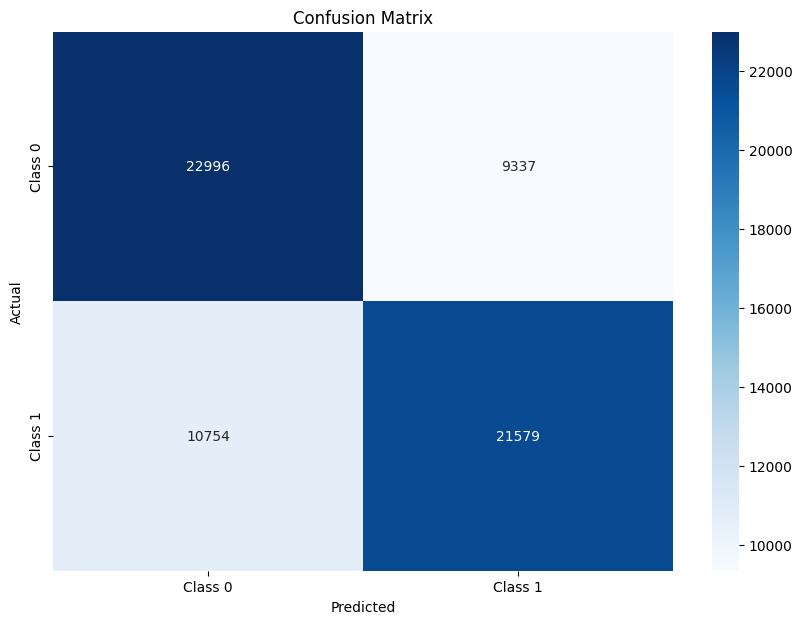

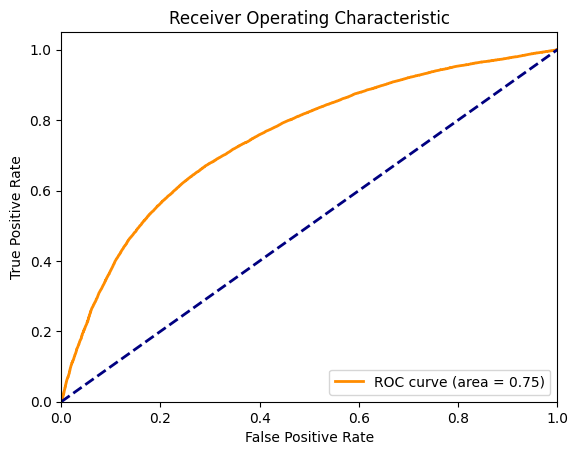

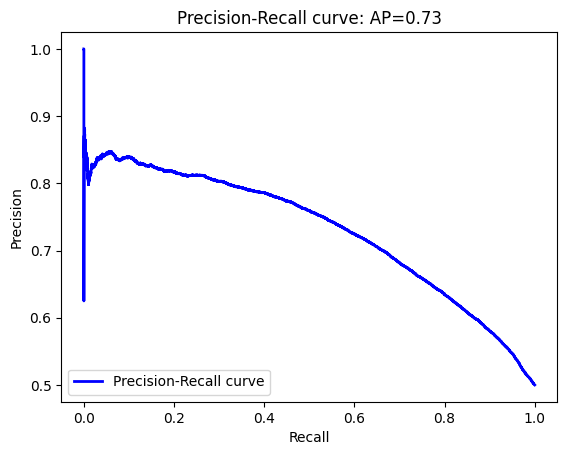

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# Print classification report
print("Classification Report:")
print(classification_report(all_labels.cpu(), predicted.cpu(), target_names=['Class 0', 'Class 1']))

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels.cpu(), predicted.cpu())
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Compute and plot ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels.cpu(), all_outputs[:, 1].cpu())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Compute and plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(all_labels.cpu(), all_outputs[:, 1].cpu())
average_precision = average_precision_score(all_labels.cpu(), all_outputs[:, 1].cpu())
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve: AP={average_precision:0.2f}')
plt.legend(loc="lower left")
plt.show()
